In [28]:
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
import os
from collections import Counter
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import time
from datetime import datetime
from dateutil.parser import parse

In [29]:
#df for cornona cases

df_corona=pd.read_csv("corona_data.csv")

df_corona = df_corona.iloc[:72]
#rename unnamed columns to Date

df_corona.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
#same dates format to Climate change 
Date_list= df_corona["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df_corona["Date"]=dates
print(df_corona)




          Date  total_cases  total_deaths  log_total_cases  log_total_deaths
0   2020-01-22          555            17         2.744293          1.230449
1   2020-01-23          654            18         2.815578          1.255273
2   2020-01-24          941            26         2.973590          1.414973
3   2020-01-25         1434            42         3.156549          1.623249
4   2020-01-26         2118            56         3.325926          1.748188
..         ...          ...           ...              ...               ...
67  2020-03-29       720140         33925         5.857417          4.530520
68  2020-03-30       782389         37582         5.893423          4.574980
69  2020-03-31       857487         42107         5.933228          4.624354
70  2020-04-01       932605         47180         5.969698          4.673758
71  2020-04-02      1013466         52983         6.005809          4.724137

[72 rows x 5 columns]


In [59]:
#df for climate change
df_c_Change=pd.read_csv("old_climate_data.csv")
df2=df_c_Change.drop([0, 1])
df2.reset_index(drop=True, inplace=True)
df2.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
Date_list= df2["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df2["Date"]=dates
df2.rename( columns={'id':'tweet_count'}, inplace=True )
df2.rename( columns={'sentiment':'pos_count'}, inplace=True )
df2.rename( columns={'sentiment.1':'neg_count'}, inplace=True )
df2.rename( columns={'sentiment.2':'neu_count'}, inplace=True )

#result = pd.concat([df_corona, df2], axis=1, join='inner')
result = df_corona.set_index('Date').join(df2.set_index('Date'), on='Date')
print(result)

            total_cases  total_deaths  log_total_cases  log_total_deaths  \
Date                                                                       
2020-01-22          555            17         2.744293          1.230449   
2020-01-23          654            18         2.815578          1.255273   
2020-01-24          941            26         2.973590          1.414973   
2020-01-25         1434            42         3.156549          1.623249   
2020-01-26         2118            56         3.325926          1.748188   
...                 ...           ...              ...               ...   
2020-03-29       720140         33925         5.857417          4.530520   
2020-03-30       782389         37582         5.893423          4.574980   
2020-03-31       857487         42107         5.933228          4.624354   
2020-04-01       932605         47180         5.969698          4.673758   
2020-04-02      1013466         52983         6.005809          4.724137   

           

['5228', '2717', '2795', '2128', '1504', '2000', '2050', '1948', '1730', '1770', '1319', '1200', '1871', '2380', '2195', '1896', '1900', '1423', '1355', '2049', '1982', '2019', '2070', '1832', '1140', '1290', '1947', '2364', '1925', '2020', '1870', '1217', '1211', '2019', '1911', '2026', '2377', '2290', '1309', '1305', '1824', '1942', '1913', '1927', '1625', '1057', '1198', '1663', '1712', '1772', '1541', '1407', '891', '853', '1533', '1334', '1335', '1234', '1091', '864', '1216', '1172', '1046', '1038', '1053', '971', '809', '573', '943', '958', '1038', '1411']
['2152', '1902', '1576', '1066', '935', '1241', '1198', '1275', '1075', '1132', '942', '803', '1322', '1701', '1491', '1291', '1458', '1279', '1131', '1506', '1352', '1327', '1200', '1103', '818', '915', '1252', '1517', '1184', '1364', '1215', '939', '1017', '1572', '1367', '1455', '1524', '1477', '919', '943', '1253', '1277', '1223', '1222', '1015', '814', '796', '1097', '1317', '1184', '1118', '1056', '708', '678', '1067', '9

C:\Users\Nicholas\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


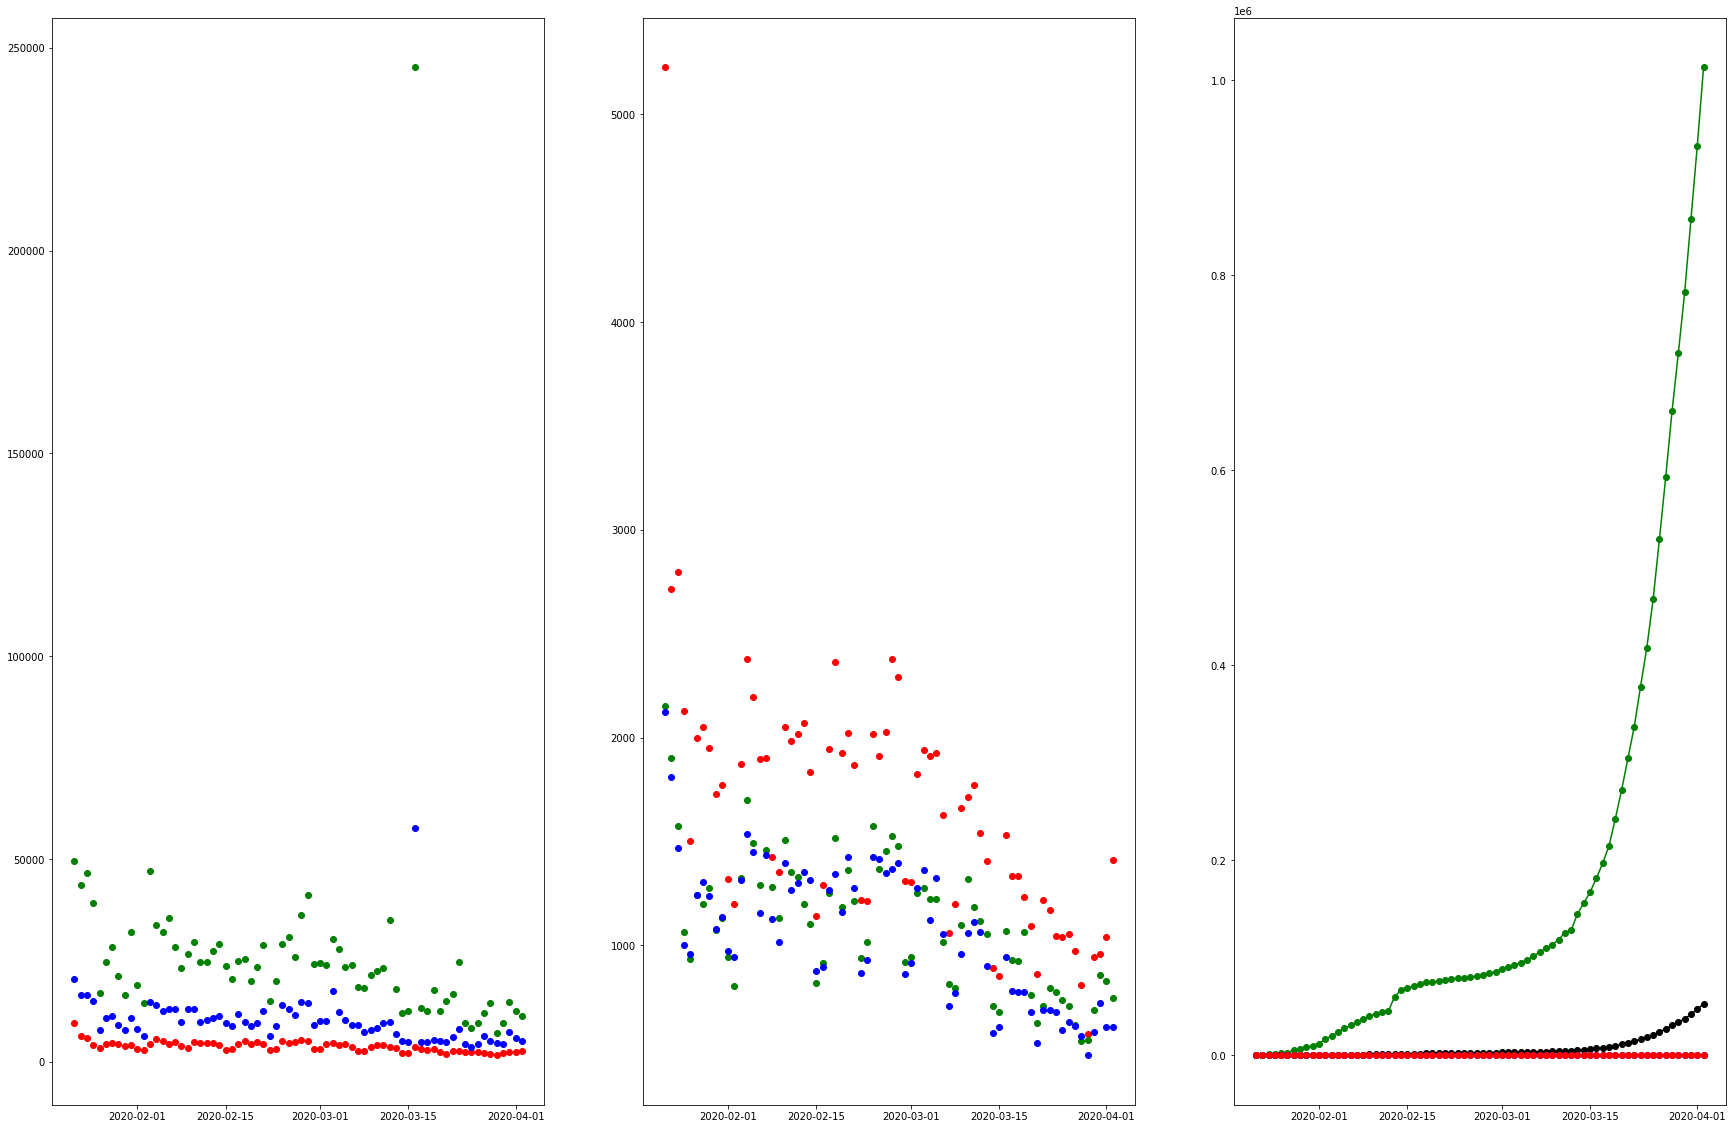

In [57]:
plt.figure(figsize=(30,20))
plt.subplot(1,3,1)
tweetid=[]
retweet_count=[]
fav_count=[]

y_colors=["red", "green", "blue"]
y_keyword=["id", "favorite_count","retweet_count"]

x_values = df2.Date
for y,c in zip(y_keyword, y_colors):
    #tweets grouped by id's
    y_values1 = list(df2[y])
    y_values1=[int(x)for x in y_values1]
    plt.scatter(x_values, y_values1, color=c, marker="o", linestyle="-") 

plt.subplot(1, 3, 2)

y_keys = ["pos_count", "neg_count","neu_count"]
for y,c in zip(y_keys, y_colors):
    #tweets grouped by id's
    y_vals = list(df2[y])
    print(y_vals)
    y_vals=[int(x)for x in y_vals]    
    
    plt.scatter(x_values, y_vals, color=c, marker="o", linestyle="-")     

y_colors=["green", "black","blue", "red"]
y_keyword1=["total_cases", "total_deaths","log_total_cases", "log_total_deaths"]

plt.subplot(1, 3,3)

x_values2=df_corona.Date
for y,c in zip(y_keyword1, y_colors):
    #tweets grouped by id's
    y_values1 = list(df_corona[y])
    y_values1=[int(x)for x in y_values1]    
    
    plt.plot(x_values2, y_values1, color=c, marker="o", linestyle="-")   
    
plt.subplot(1,3,2)
  

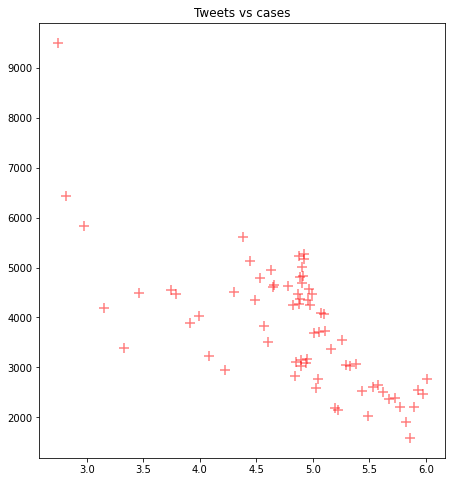

In [63]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
y_values = [int(y) for y in list(result['tweet_count'])]
x_values = list(result['log_total_cases'])
plt.title("Tweets vs cases")
plt.scatter(x_values, y_values,
            s=100,
            c="red",
            marker="+",
            alpha=0.5)